In [45]:
# copied from viz_bnef_results
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

import vapor
from vapor.models import Cambium

In [49]:
os.getcwd()

'/lustre/eaglefs/projects/vapor/vapor-open'

In [50]:
# --- Load Regional Best ---
results = pd.read_pickle(os.path.join('results','bnef_results_newtb.pkl'))
results['scenario'] = 'Mid Cost'
results['batt_size'] = 0
results.rename({'geometry':'point', 'region':'pca'}, axis='columns', inplace=True)

In [51]:
# --- Merge on Regions ---
region_map = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
region_map = region_map[['pca','rto','census_reg','inter']].drop_duplicates()

census_reg_dict = {
    'PA':'West',
    'MTN':'West',
    'ENC':'Midwest',
    'WNC':'Midwest',
    'WSC':'South',
    'MA':'Northeast',
    'NE':'Northeast',
    'ESC':'South',
    'SA':'South'
}
region_map['census_div'] = region_map['census_reg'].map(census_reg_dict)

df = results.merge(region_map, on='pca', how='left')


In [14]:
years = [str(i) for i in range(2014,2051,1)]
cambium_cols = [i for i in df.columns if 'cambium' in i]
cambium_cols = [i for i in cambium_cols if i[-4:] in years]


# --- subset cambium columns ---
c_df = df[cambium_cols + list(region_map.columns) + ['project_id','tech','system_capacity']]

# --- melt ---
c_df = c_df.melt(id_vars= list(region_map.columns) +['project_id','tech','system_capacity'])
c_df['year'] = [int(i[-4:]) for i in c_df['variable']]
c_df['variable'] = [str(i[:-5]) for i in c_df['variable']]

c_df['value_mw'] = c_df['value'] / c_df['system_capacity'] * 1000
c_df.drop_duplicates(inplace=True)
c_df.head(5)

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_portfolio_value,5.757466,2020,1.279437
2,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_portfolio_value,3.874997,2020,0.430555
3,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_portfolio_value,0.000000,2020,0.000000
4,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_portfolio_value,0.000000,2020,0.000000
5,p10,rto4,PA,western,West,4776,wind,58800.0,cambium_portfolio_value,0.000000,2020,0.000000


In [56]:
"','".join(c_df.columns)

"pca','rto','census_reg','inter','census_div','project_id','tech','system_capacity','variable','value','year','value_mw"

### NOTE: oddity
Results show:
* solar pv typically offsets lower emissions when using lrmer vs avg (_to be expected_)
* wind typically offsets _higher_ emissions using lrmer vs. avg

In [13]:
temp_lrmer = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ].groupby(['inter', 'tech'], as_index=False)['value'].mean()
temp_avg = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_avg') &\
         (c_df['year'] == 2020)\
        ].groupby(['inter', 'tech'], as_index=False)['value'].mean()
temp_comb = temp_avg.merge(temp_lrmer, on=['inter', 'tech'], suffixes=('_avg', '_lrmer'))
temp_comb['perc_diff'] = ((temp_comb['value_avg'] - temp_comb['value_lrmer'])/temp_comb['value_avg'])*100
temp_comb

,inter,tech,value_avg,value_lrmer,perc_diff
0,eastern,pv,13040.921018,10773.017887,17.390667
1,eastern,wind,56147.001519,99038.139839,-76.390791
2,texas,pv,40446.074322,31894.742015,21.142552
3,texas,wind,23183.103945,51459.955335,-121.971810
4,western,pv,8343.975948,7842.109560,6.014715
5,western,wind,10696.147098,11357.664145,-6.184629


In [85]:
temp_lrmer = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_lrmer') &\
         (c_df['year'] == 2020)\
        ]
temp_avg = c_df.loc[\
         (c_df['variable'] == 'cambium_co2_rate_avg') &\
         (c_df['year'] == 2020)\
        ]
merge_cols = ['pca','rto','census_reg','inter','census_div','project_id','tech','system_capacity','year']
temp_comb = temp_avg.drop(columns=['variable', 'value_mw']).merge(temp_lrmer.drop(columns=['variable', 'value_mw']), 
                           on= merge_cols, 
                           suffixes=('_avg', '_lrmer'))

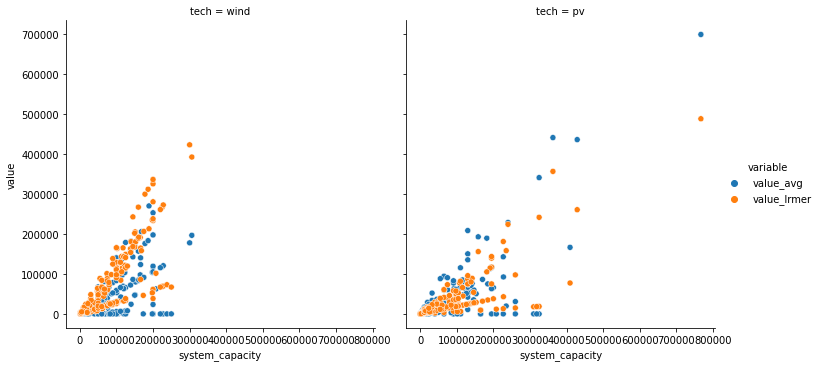

In [86]:
sns.relplot(
    data= temp_comb.melt(id_vars= merge_cols), x="system_capacity", y="value",
    col="tech", hue="variable",kind="scatter"
)
#sns.scatterplot(data=temp_comb.loc[temp_comb.tech=='wind'], x="system_capacity", y="value", hue="variable")

In [92]:
temp_comb['perc_diff'] = (temp_comb['value_avg']/temp_comb['system_capacity'] -\
                          temp_comb['value_lrmer']/temp_comb['system_capacity'])/(temp_comb['value_avg']/temp_comb['system_capacity'])

In [93]:
temp_comb.head()

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,value_avg,year,value_lrmer,perc_diff
0,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,1548.940826,2020,2001.786130,-0.292358
1,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,446.926222,2020,6712.329588,-14.018876
2,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,9535.397526,2020,16198.000857,-0.698723
3,p62,rto10,WSC,texas,South,4775,wind,90800.0,4630.298425,2020,23938.600085,-4.169991
4,p10,rto4,PA,western,West,4776,wind,58800.0,26388.136092,2020,12776.870472,0.515810
